In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [3]:
#pickle objects
def make_pickle(obj, filename):
    with open(filename, 'wb') as picklefile:
        pickle.dump(obj, picklefile)

#open pickled objects
def open_pickle(filename):
    with open(filename, 'rb') as picklefile:
        return pickle.load(picklefile)

In [4]:
def print_scores(name, model):
    print name
    #model.fit(X_train, y_train)
    y_pred_in_sample = model.predict(X_train)
    print 'in sample:', metrics.accuracy_score(y_train, y_pred_in_sample)
    y_pred_out_sample = model.predict(X_test)
    print 'out of sample:', metrics.accuracy_score(y_test, y_pred_out_sample)
    print metrics.classification_report(y_test, y_pred_out_sample)

In [5]:
def get_scores(name, model):
    #model.fit(X_train, y_train)
    y_pred_in_sample = model.predict(X_train)
    acc_in_sample = metrics.accuracy_score(y_train, y_pred_in_sample)
    y_pred_out_sample = model.predict(X_test)
    acc_out_sample = metrics.accuracy_score(y_test, y_pred_out_sample)
    return name, acc_in_sample, acc_out_sample

In [6]:
def plot_acc(dct):
    accuracies = pd.DataFrame()

    for name, model in dct.items():
        #print name
        name, acc_in_sample, acc_out_sample = get_scores(name, model)
        accuracies = accuracies.append(pd.Series((name, 'in', acc_in_sample)), ignore_index=True)
        accuracies = accuracies.append(pd.Series((name, 'out', acc_out_sample)), ignore_index=True)
        print_scores(name, model)

    columns={0: 'model_type', 1: 'sample_type', 2: 'accuracy'}
    accuracies.rename(columns=columns, inplace=True)
    
    #sns.barplot(x='model_type', y='accuracy', hue='sample_type', data=accuracies);
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(1, 1, 1)
    sns.pointplot(x='sample_type', y='accuracy', hue='model_type', data=accuracies, ax=ax, markers='o')
    y_min = 0.5
    y_max = 1.0
    ax.set_xbound(-0.025, 1.025)
    ax.vlines(x=0, ymin=y_min, ymax=y_max)
    ax.vlines(x=1, ymin=y_min, ymax=y_max)
    ax.set_ybound(y_min, y_max)
    ax.set_frame_on(False);

In [7]:
def grid(model):
    model_grid = GridSearchCV(model,
                              params,
                              n_jobs=-1,
                              scoring = 'f1',
                              cv=10)
    model_grid.fit(X_train_all, y_train)
    best_model = model_grid.best_estimator_
    print 'Best CV score:', model_grid.best_score_
    print best_model
    return best_model

In [8]:
def rand(model):
    model_rand = RandomizedSearchCV(model,
                                    params,
                                    n_jobs=-1,
                                    n_iter=10,
                                    scoring = 'f1',
                                    cv=10, 
                                    random_state=16)
    model_rand.fit(X_train_all, y_train)
    best_model = model_rand.best_estimator_
    print 'Best CV score:', model_rand.best_score_
    print best_model
    return best_model

In [9]:
X_train_all, X_test_all, y_train, y_test = open_pickle('../data/processed/train_test.pkl')

In [71]:
X_train_all.drop('MWRA', axis=1, inplace=True)
X_test_all.drop('MWRA', axis=1, inplace=True)

In [10]:
len(X_test_all)

120

### Make models

### _Dummy_

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
dummy = DummyClassifier(random_state=16, strategy='most_frequent')
dummy.fit(X_train_all, y_train)

DummyClassifier(constant=None, random_state=16, strategy='most_frequent')

### _KNN_

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [14]:
knn = KNeighborsClassifier()
knn.fit(X_train_all, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [15]:
knn_to_fit = KNeighborsClassifier()
k = range(1,101)
weight_options = ['uniform', 'distance']
algorithms =  ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_sizes = [2, 5, 10, 30, 50, 100]
params={'n_neighbors': k,'weights': weight_options, 'algorithm': algorithms, 'leaf_size': leaf_sizes}

In [16]:
%%time
knn_grid = grid(knn_to_fit)

Best CV score: 0.758162398488
KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=63, p=2,
           weights='distance')
CPU times: user 3min 34s, sys: 13.9 s, total: 3min 48s
Wall time: 4min 50s


In [17]:
%%time
knn_rand = rand(knn_to_fit)

Best CV score: 0.748597970733
KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=73, p=2,
           weights='distance')
CPU times: user 472 ms, sys: 106 ms, total: 578 ms
Wall time: 1.24 s


### _Logistic Regression_

In [18]:
from sklearn.linear_model import LogisticRegressionCV

In [19]:
#l1 penalty
logreg_l1 = LogisticRegressionCV(class_weight='balanced',
                                 cv=10,
                                 penalty='l1',
                                 solver='liblinear',
                                 #n_job=-1,
                                 random_state=16)
logreg_l1.fit(X_train_all, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=16,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [20]:
#l2 penalty
logreg_l2 = LogisticRegressionCV(class_weight='balanced',
                                 cv=10,
                                 penalty='l2',
                                 solver='liblinear',
                                 #n_jobs=-1,
                                 random_state=16)
logreg_l2.fit(X_train_all, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=16,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [21]:
logreg_to_fit = LogisticRegressionCV(solver='liblinear', random_state=16)
class_weights = [None, 'balanced']
penalties = ['l1', 'l2']
params={'class_weight': class_weights, 'penalty': penalties}

In [22]:
%%time
logreg_grid = grid(logreg_to_fit)

Best CV score: 0.765890902974
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=16,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)
CPU times: user 956 ms, sys: 72 ms, total: 1.03 s
Wall time: 5.64 s


In [23]:
%%time
logreg_rand = RandomizedSearchCV(logreg_to_fit,
                   params,
                   n_jobs=-1,
                   n_iter=3,
                   scoring = 'accuracy',
                   cv=10, 
                   random_state=16)
logreg_rand.fit(X_train_all, y_train)
print logreg_rand.best_score_
print logreg_rand.best_estimator_

0.684782608696
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=16,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)
CPU times: user 868 ms, sys: 65.9 ms, total: 934 ms
Wall time: 5.41 s


### _SVM_

In [24]:
from sklearn.svm import SVC

In [25]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train_all, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train_all, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_all, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X_train_all, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
svm_to_fit = SVC()
Cs = [0.001, 0.01, 0.1, 1.0, 10.0]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [0.001, 0.01, 0.1, 1]
class_weights = [None, 'balanced']
params={'C': Cs, 'kernel': kernels,'gamma': gammas, 'class_weight': class_weights}

In [30]:
%%time
svm_grid = grid(svm_to_fit)

/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/skle

Best CV score: 0.752448088411
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 8.01 s, sys: 845 ms, total: 8.85 s
Wall time: 43.9 s


In [31]:
%%time
svm_rand = rand(svm_to_fit)

/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best CV score: 0.751690799571
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 636 ms, sys: 154 ms, total: 790 ms
Wall time: 869 ms


### _Decision Tree_

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
dt = DecisionTreeClassifier(random_state=16)
dt.fit(X_train_all, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=16, splitter='best')

In [34]:
dt_to_fit = DecisionTreeClassifier(random_state=16)
max_depths = range(1,20)
class_weights = [None, 'balanced']
min_samples = [2, 5, 10, 20, 50, 100]
params={'max_depth': max_depths, 'class_weight': class_weights, 'min_samples_leaf': min_samples}

In [35]:
%%time
dt_grid = grid(dt_to_fit)

Best CV score: 0.744077344934
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=16, splitter='best')
CPU times: user 8.4 s, sys: 1.94 s, total: 10.3 s
Wall time: 9.03 s


In [36]:
%%time
dt_rand = rand(dt_to_fit)

Best CV score: 0.743379862481
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=16, splitter='best')
CPU times: user 463 ms, sys: 136 ms, total: 598 ms
Wall time: 656 ms


### _Random Forest_

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
rf = RandomForestClassifier(random_state=16, oob_score=True)
rf.fit(X_train_all, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=16,
            verbose=0, warm_start=False)

In [73]:
rf_to_fit = RandomForestClassifier(random_state=16, oob_score=True)
n_trees = [5, 50, 500]
max_depths = range(1,20)
class_weights = [None, 'balanced']
min_samples = [2, 5, 10, 20, 50, 100]
params={'n_estimators': n_trees, 'max_depth': max_depths, 'class_weight': class_weights, 'min_samples_split': min_samples}

In [74]:
%%time
rf_rand = rand(rf_to_fit)

Best CV score: 0.758276307242
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=16,
            verbose=0, warm_start=False)
CPU times: user 3.37 s, sys: 173 ms, total: 3.54 s
Wall time: 30.2 s


### Compare models

In [41]:
dummies = {'dummy': dummy}

knns = {'knn': knn,
        'knn_grid': knn_grid, 
        'knn_rand': knn_rand}

logregs = {'logreg l1': logreg_l1,
           'logreg l2': logreg_l2, 
           'logreg_grid': logreg_grid, 
           'logreg_rand': logreg_rand}

svms = {'svm_linear': svm_linear,
        'svm_poly': svm_poly,
        'svm_rbf': svm_rbf,
        'svm_sigmoid': svm_sigmoid,
        'svm_grid': svm_grid, 
        'svm_rand': svm_rand}

trees = {'decisiontree': dt,
         'decisiontree_grid': dt_grid, 
         'decisiontrees_rand': dt_rand}

forests = {'randomforest': rf,
           'randomforest_rand': rf_rand}

In [42]:
X_train = X_train_all
X_test = X_test_all

dummy
in sample: 0.595652173913
out of sample: 0.591666666667
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        49
        1.0       0.59      1.00      0.74        71

avg / total       0.35      0.59      0.44       120



/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


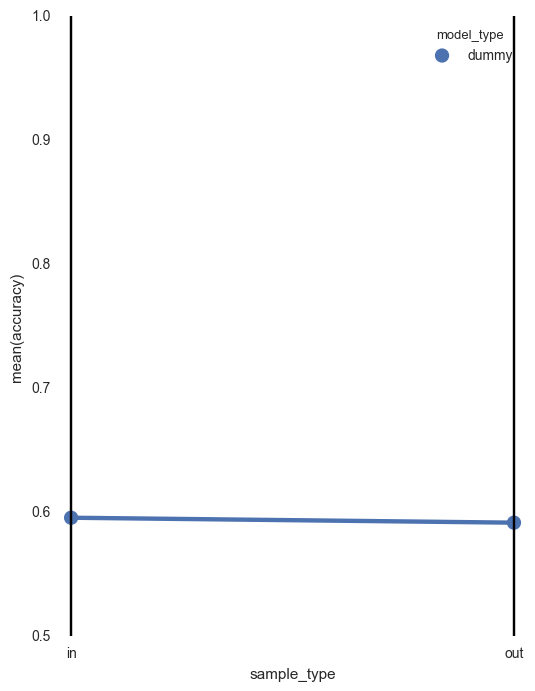

In [43]:
plot_acc(dummies)

knn
in sample: 0.752173913043
out of sample: 0.641666666667
             precision    recall  f1-score   support

        0.0       0.57      0.49      0.53        49
        1.0       0.68      0.75      0.71        71

avg / total       0.64      0.64      0.64       120

knn_rand
in sample: 0.984782608696
out of sample: 0.708333333333
             precision    recall  f1-score   support

        0.0       0.72      0.47      0.57        49
        1.0       0.70      0.87      0.78        71

avg / total       0.71      0.71      0.69       120

knn_grid
in sample: 0.984782608696
out of sample: 0.708333333333
             precision    recall  f1-score   support

        0.0       0.71      0.49      0.58        49
        1.0       0.71      0.86      0.78        71

avg / total       0.71      0.71      0.70       120



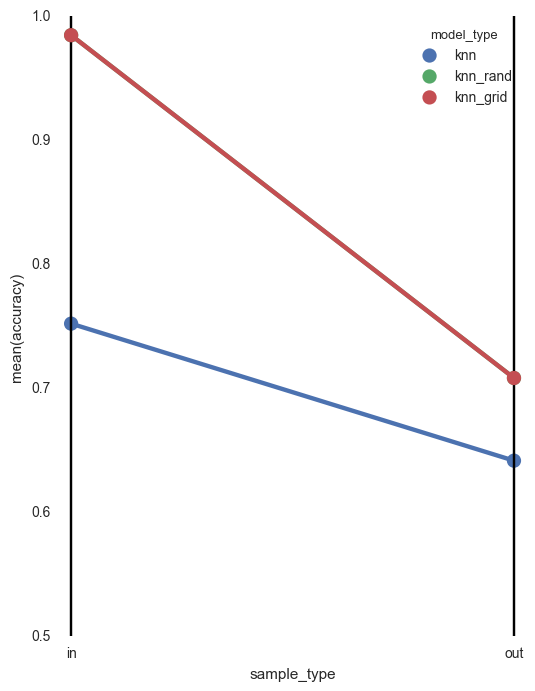

In [44]:
plot_acc(knns)

logreg_grid
in sample: 0.695652173913
out of sample: 0.675
             precision    recall  f1-score   support

        0.0       0.68      0.39      0.49        49
        1.0       0.67      0.87      0.76        71

avg / total       0.68      0.68      0.65       120

logreg_rand
in sample: 0.695652173913
out of sample: 0.675
             precision    recall  f1-score   support

        0.0       0.68      0.39      0.49        49
        1.0       0.67      0.87      0.76        71

avg / total       0.68      0.68      0.65       120

logreg l1
in sample: 0.69347826087
out of sample: 0.666666666667
             precision    recall  f1-score   support

        0.0       0.60      0.53      0.57        49
        1.0       0.70      0.76      0.73        71

avg / total       0.66      0.67      0.66       120

logreg l2
in sample: 0.686956521739
out of sample: 0.683333333333
             precision    recall  f1-score   support

        0.0       0.62      0.57      0.60        49

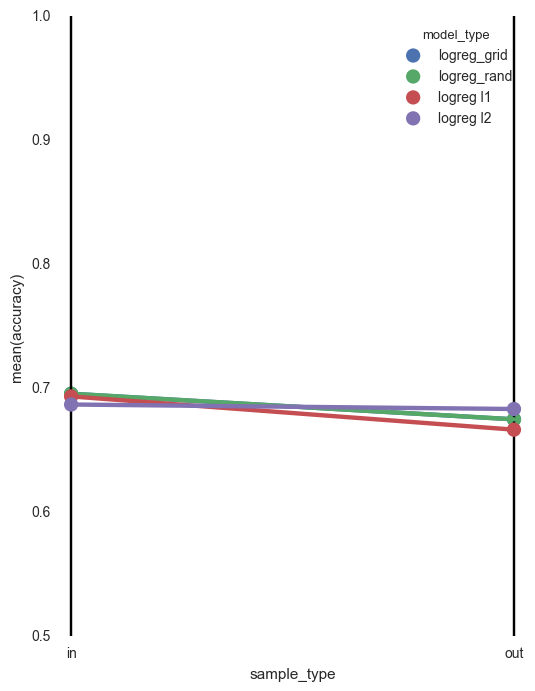

In [45]:
plot_acc(logregs)

svm_rbf
in sample: 0.680434782609
out of sample: 0.683333333333
             precision    recall  f1-score   support

        0.0       0.70      0.39      0.50        49
        1.0       0.68      0.89      0.77        71

avg / total       0.69      0.68      0.66       120

svm_linear
in sample: 0.667391304348
out of sample: 0.658333333333
             precision    recall  f1-score   support

        0.0       0.64      0.37      0.47        49
        1.0       0.66      0.86      0.75        71

avg / total       0.65      0.66      0.63       120

svm_poly
in sample: 0.617391304348
out of sample: 0.6
             precision    recall  f1-score   support

        0.0       1.00      0.02      0.04        49
        1.0       0.60      1.00      0.75        71

avg / total       0.76      0.60      0.46       120

svm_rand
in sample: 0.667391304348
out of sample: 0.658333333333
             precision    recall  f1-score   support

        0.0       0.64      0.37      0.47        4

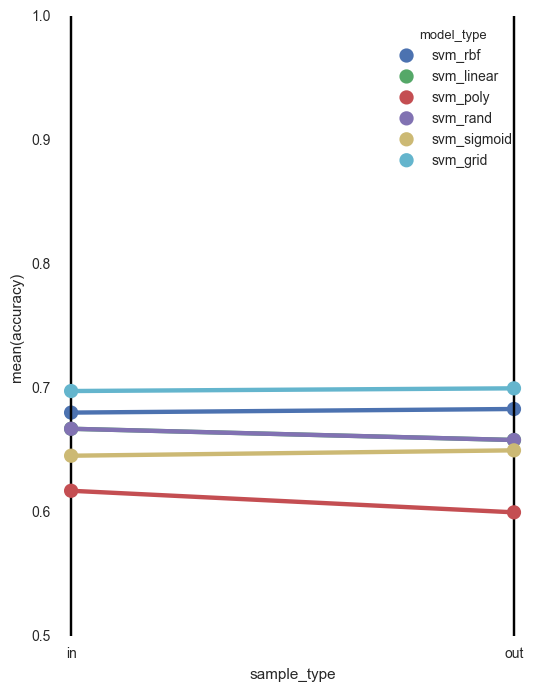

In [46]:
plot_acc(svms)

decisiontree_grid
in sample: 0.697826086957
out of sample: 0.675
             precision    recall  f1-score   support

        0.0       0.67      0.41      0.51        49
        1.0       0.68      0.86      0.76        71

avg / total       0.67      0.68      0.66       120

decisiontree
in sample: 0.984782608696
out of sample: 0.633333333333
             precision    recall  f1-score   support

        0.0       0.55      0.53      0.54        49
        1.0       0.68      0.70      0.69        71

avg / total       0.63      0.63      0.63       120

decisiontrees_rand
in sample: 0.654347826087
out of sample: 0.658333333333
             precision    recall  f1-score   support

        0.0       0.65      0.35      0.45        49
        1.0       0.66      0.87      0.75        71

avg / total       0.66      0.66      0.63       120



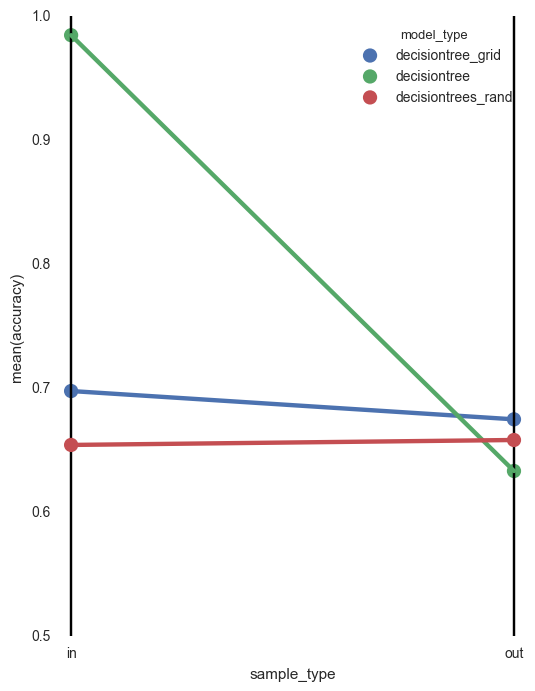

In [47]:
plot_acc(trees)

In [75]:
plot_acc(forests)

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 14 

In [49]:
X_train_all.columns

Index([u'SURVEY', u'PB_90', u'MWRA', u'EJ', u'GW_RATIO', u'SCH_PRI',
       u'SCH_PUB', u'SCH_SPE', u'SCH_SPU', u'PWS_NC', u'PWS_NTNC',
       u'TOTAL_VAL', u'YEAR_SINCE_1800', u'COUNT_CONN', u'TOTAL_INTAKES'],
      dtype='object')

Feature ranking:
1. Age of Building (0.230884)
2. Number of Connections (0.169701)
3. Number of Intakes (0.146525)
4. Parcel Value (0.124758)
5. GW Ratio (0.093879)
6. Survey Response (0.089839)
7. Public School (0.057671)
8. LCR Reporting (0.052999)
9. EJ (0.011279)
10. Private School (0.008490)
11. Special Ed School (A) (0.008026)
12. Non-transient,
non-community PWS (0.003323)
13. Special Ed School (U) (0.002341)
14. Transient,
non-community PWS (0.000285)


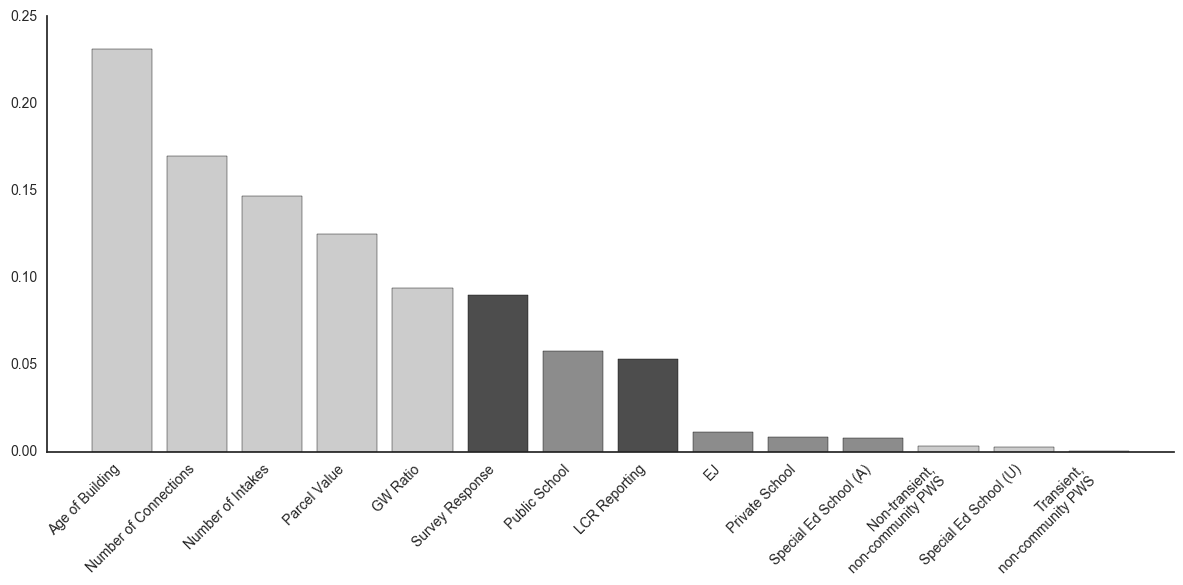

In [76]:
sns.set_style('white')
importances = rf_rand.feature_importances_

#importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_rand.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

features = np.array(['Survey Response', 'LCR Reporting', 'EJ', 'GW Ratio', 'Private School', \
            'Public School', 'Special Ed School (A)', 'Special Ed School (U)', \
            'Transient,\nnon-community PWS', 'Non-transient,\nnon-community PWS', \
           'Parcel Value', 'Age of Building', 'Number of Connections', 'Number of Intakes'])

#ar = [('four' if i % 4 == 0 else ('six' if i % 6 == 0 else i)) for i in range(1, n)]
clrs = ['0.3' if (index in [0, 1]) else ('0.55' if index in [2, 4, 5, 6] else '0.8') for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_all.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
fig_features = plt.figure(figsize=(12,6))
#plt.title("Feature importances")
sns.barplot(range(X_train_all.shape[1]), importances[indices], palette=clrs)
plt.xticks(range(X_train_all.shape[1]), features[indices], rotation=45, ha='right')
plt.xlim([-1, X_train_all.shape[1]])
plt.tight_layout()
sns.despine();
fig_features.savefig('../reports/figures/features.png')

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [52]:
def plot_roc(modelname, title, pos_label):
    y_score = modelname.predict_proba(X_test)[:,0]
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=pos_label)
    AUC = auc(fpr, tpr)
    fig_title = title + ', AUC:' + str(AUC)
    fig, ax = plt.subplots()
    fig = sns.regplot(fpr, tpr, fit_reg=False)
    fig.set(xlabel='FPR',ylabel='TPR')
    fig.axes.set_title(fig_title);

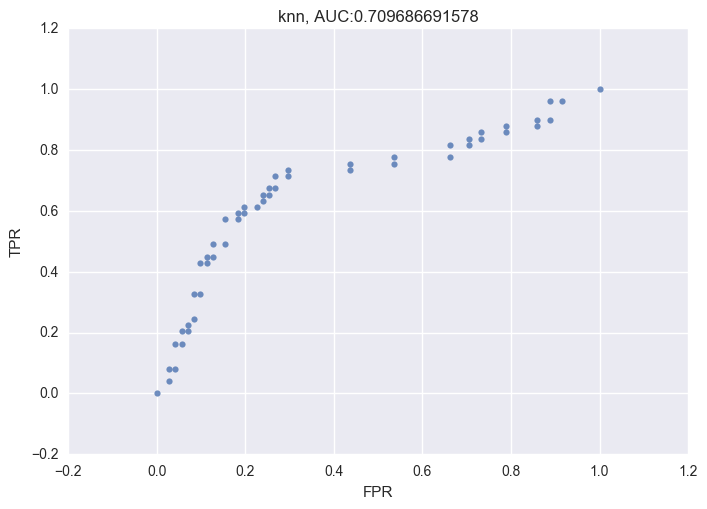

In [53]:
plot_roc(knn_grid, 'knn', pos_label=0.0)

In [54]:
print X_train_all.columns

Index([u'SURVEY', u'PB_90', u'MWRA', u'EJ', u'GW_RATIO', u'SCH_PRI',
       u'SCH_PUB', u'SCH_SPE', u'SCH_SPU', u'PWS_NC', u'PWS_NTNC',
       u'TOTAL_VAL', u'YEAR_SINCE_1800', u'COUNT_CONN', u'TOTAL_INTAKES'],
      dtype='object')


In [55]:
X = pd.concat((X_train_all, X_test_all)).as_matrix()
y = pd.concat((y_train, y_test)).as_matrix()

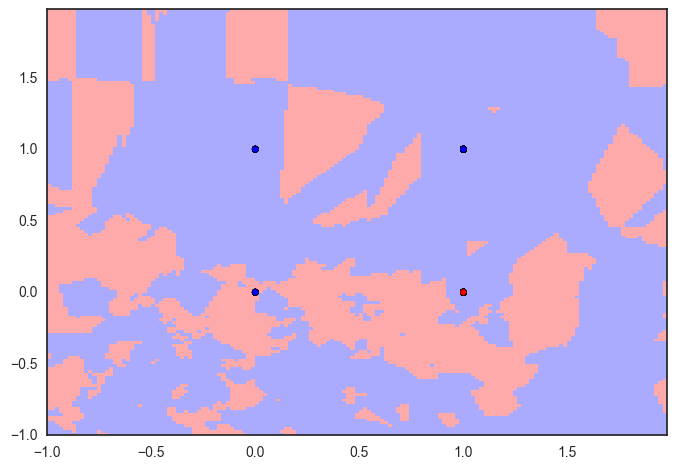

In [64]:
#print(__doc__)

#import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#from sklearn import neighbors, datasets

n_neighbors = 5
#n_neighbors = 63

# import some data to play with
#iris = datasets.load_iris()
X_cut = X[:, (11,13)]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
#y = iris.target



h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

#for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    #clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    #clf.fit(X, y)

#knn_grid.fit(X_cut,y)
clf = KNeighborsClassifier(n_neighbors)
clf.fit(X_cut,y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i, weights = '%s')"
#          % (n_neighbors, weights))

plt.show()

In [63]:
sns.set_style('white')
k_range = list(range(1, 200))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=k, p=2,
           weights='distance')
    scores = cross_val_score(knn, X_train_all, y_train, scoring='accuracy')
    k_scores.append(scores.mean())
#print(k_scores)

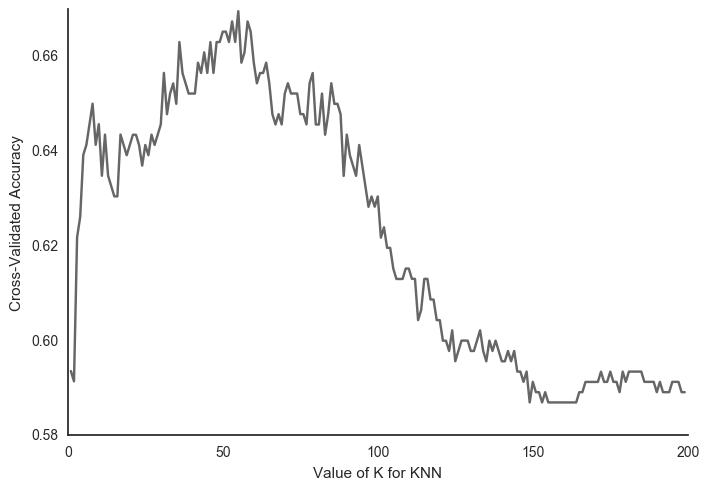

In [65]:
#fig, ax = plt.subplots(figsize=(10, 4))
fig = plt.figure()
plt.plot(k_range, k_scores, color='0.40')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
sns.despine();
fig.savefig('../reports/figures/k_scores.png')

In [66]:
precision = [0.35, 0.71, 0.69]
recall = [0.59, 0.71, 0.68]
f1_score = [0.44, 0.70, 0.68]
y = ['Dummy', 'KNN', 'Random Forest']

In [67]:
sns.set_style('white')
clrs = ['0.40' if (_y == 'KNN') else '0.75' for _y in y]

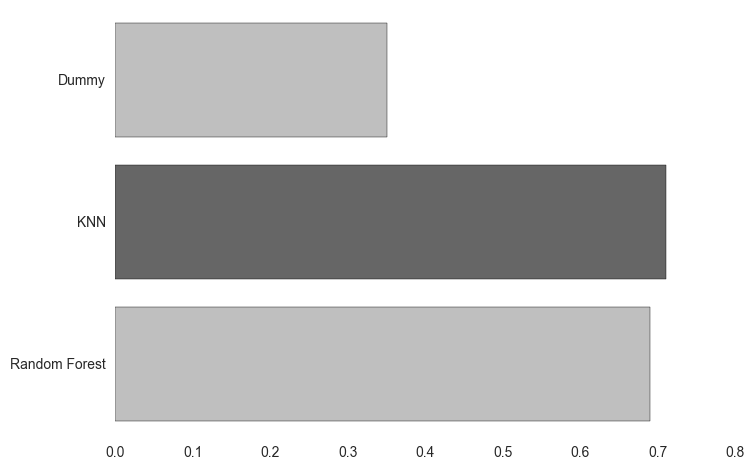

In [68]:
fig_precision = sns.barplot(precision, y, palette=clrs)
sns.despine(left=True, bottom=True);
fig_precision.get_figure().savefig('../reports/figures/precision.png')

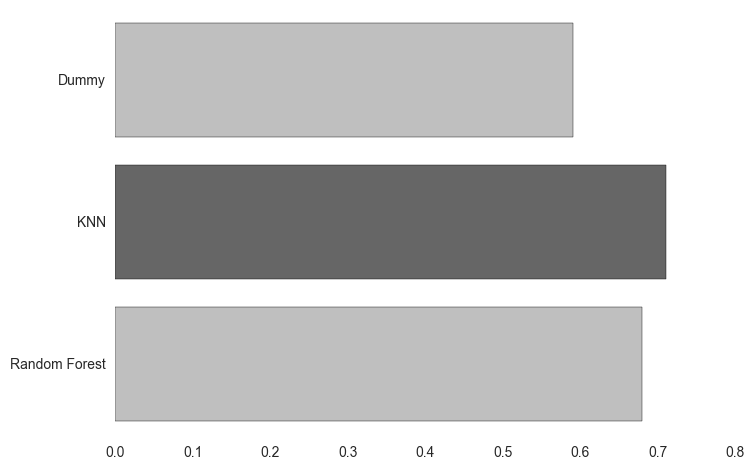

In [69]:
fig_recall = sns.barplot(recall, y, palette=clrs)
sns.despine(left=True, bottom=True);
fig_recall.get_figure().savefig('../reports/figures/recall.png')

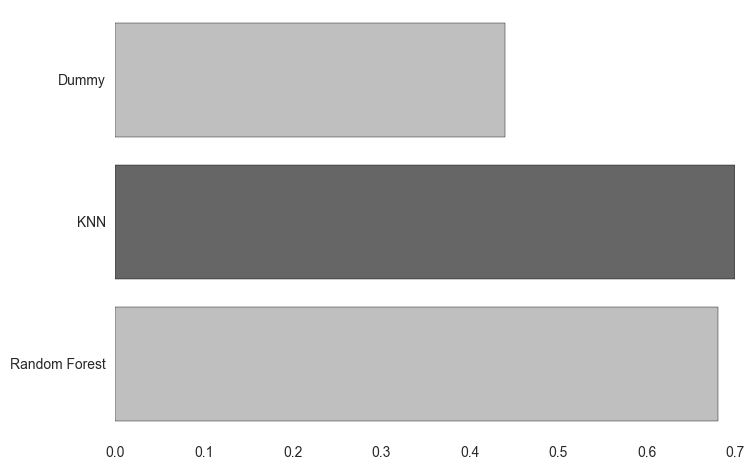

In [70]:
fig_f1 = sns.barplot(f1_score, y, palette=clrs)
sns.despine(left=True, bottom=True);
fig_f1.get_figure().savefig('../reports/figures/f1.png')

In [77]:
14+16+11+11+5+13

70